# Install libraries 


In [1]:
import sys, os, json
import mne, sklearn, wandb
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from nilearn import datasets, image, masking, plotting
from nilearn.input_data import NiftiLabelsMasker


# animation part
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
# from celluloid import Camera   # it is convinient method to animate
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation


## torch libraries 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, Subset

from pytorch_model_summary import summary


/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
%load_ext autoreload
%autoreload 2
sys.path.insert(1, os.path.realpath(os.path.pardir))

from utils import get_datasets
from utils import preproc
from utils import torch_dataset
from utils import train_utils
from utils import inference
from utils.models_arch import autoencoder_new

# Set all hyperparameters
- Cuda and GPU.
- Parameters of dataset. 
- random seed( if necessary). 


In [3]:
# import random

# torch.manual_seed(0)
# random.seed(0)  # python operation seed
# np.random.seed(0)

# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

print(torch.cuda.is_available(), torch.cuda.device_count())
torch.cuda.set_device(0)

True 4


In [4]:
import seaborn as sns
sns.set()

In [34]:
np.mean([0.61,  0.11, 0.63, 0.08]), 
np.std([[0.47,  0.45, 0.40]], ddof=1)


0.03605551275463987

(0.0, 0.6)

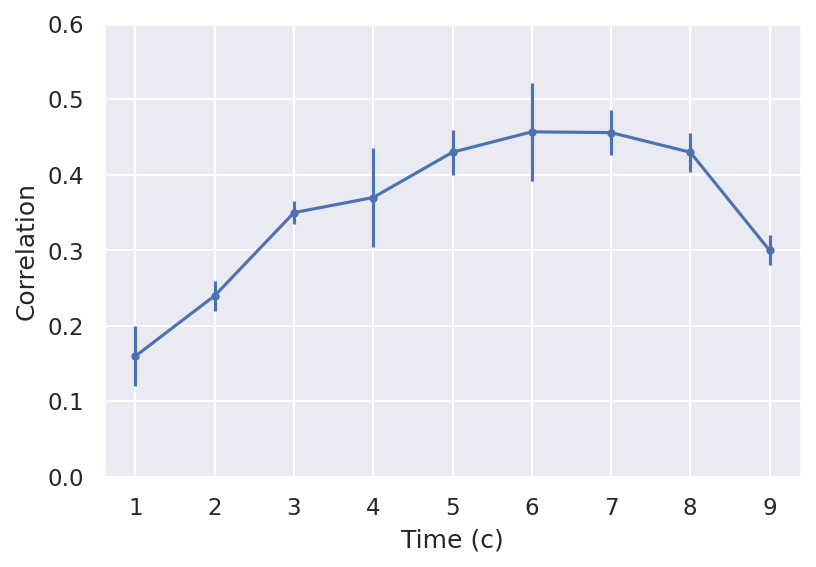

In [6]:
x = np.arange(1, 10)
y = [0.16, 0.24, 0.35, 0.37, 0.43, 0.457, 0.456, 0.43, 0.3]
y_err = [0.04, 0.02, 0.015, 0.065, 0.03, 0.065, 0.03, 0.026, 0.02]


fig= plt.figure(dpi = 150)
# plt.plot(x, y, yerr = , '*', c= 'b')
plt.errorbar(x, y, yerr=y_err, fmt = '.-' )
plt.xlabel('Time (c)')
plt.ylabel('Correlation')

plt.ylim(0, 0.6)

In [7]:
# fig.savefig('../figures/time_delay_sub_1_AE.pdf')

In [8]:
print(np.round(np.logspace(np.log10(2), np.log10(99), 16), 1))

[ 2.   2.6  3.4  4.4  5.7  7.3  9.5 12.4 16.  20.8 27.  35.  45.4 58.8
 76.3 99. ]


In [9]:
config = dict(  
                dataset_name = 'CWL', # CWL
                new_fps=100, 
                freqs = np.logspace(np.log10(2), np.log10(99), 16), 
    
                n_channels = 30, # 30 
                n_roi = 6,
                
                bold_delay = 6,
                to_many = True,
                random_subsample = True,
                sample_per_epoch = 2048, 
                WINDOW_SIZE = 2048,
                    
                optimizer='adam',
                lr=3e-4,
                weight_decay=0, 
                batch_size=16, 
                
                preproc_type = 'dB_log',
                loss_function = 'mse_corr_manifold', 
                model_type = '1D_CNN_AE_wav2vec2'
                )


hp_autoencoder = dict(n_electrodes=config['n_channels'],
                      n_freqs = len(config['freqs']),
                      n_channels_out = config['n_roi'],

                     channels = [128, 128, 128, 128], 
                     kernel_sizes=[5, 5, 3],
                     strides=[8, 8, 4], 
                     dilation=[1, 1, 1], 
                     decoder_reduce=4
                     )


config = {**hp_autoencoder, **config}

params_train = {'batch_size': config['batch_size'],
                'shuffle': True,
                'num_workers': 0}

params_val = {'batch_size': config['batch_size'],
              'shuffle': False}

# Upload preprocessed dataset from np files. 
It should accelerate speed of experiments.

In [10]:
patient = 'trio1'
path_to_dataset = '../data/eyes_open_closed_dataset/'
dataset_name = 'CWL'
remove_confounds = True
# common/koval_alvi/fmri_eeg_project/


df_eeg, df_fmri, labels_roi = get_datasets.download_cwl_dataset(patient, path_to_dataset, 
                                                                    remove_confounds=remove_confounds,
                                                                    verbose=True)
# df_eeg_align, df_fmri_interp, fps = get_datasets.interpolate_df_eeg_fmri(df_eeg, df_fmri)



ALL path:  ../data/eyes_open_closed_dataset/trio1/CWL_Data/eeg/in-scan/trio1_mrcorrected_eoec_in-scan_hpump-off.set ../data/eyes_open_closed_dataset/trio1/CWL_Data/mri/epi_normalized/rwatrio1_eoec_in-scan_hpump-off.nii ../data/eyes_open_closed_dataset/trio1/CWL_Data/mri/epi_motionparams/rp_atrio1_eoec_in-scan_hpump-off.txt


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:215: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:215: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:173: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_confound = pd.read_csv(motion_params_path, sep = '  ', header=None)


Dimension of our EEG data:  (303601, 31)
Dimension of our fMRi data:  (61, 72, 61, 146)
Dimension of our fMRi Roi data:  (143, 18)
fMRI info :  1.95
RoI:  ['Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens', 'time']


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:261: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  return df_eeg, df_fmri, df_fmri.drop(['time'], 1).columns.to_list()


In [11]:
eeg_path_set_file = os.path.join(path_to_dataset, f'{patient}/CWL_Data/eeg/in-scan/{patient}_mrcorrected_eoec_in-scan_hpump-off.set')
## EEG preprocessing
raw = mne.io.read_raw_eeglab(eeg_path_set_file)

# df_eeg = raw.to_data_frame()
# vector_exclude = ['EOG', 'ECG', 'CW1', 'CW2', 'CW3', 'CW4', 'CW5', 'CW6']
# df_eeg = df_eeg.drop(vector_exclude, axis=1)

/tmp/ipykernel_2552/478618368.py:3: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/tmp/ipykernel_2552/478618368.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)


In [12]:
standart_montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(ch_names=standart_montage.ch_names, sfreq=100, ch_types='eeg')
info = info.pick_channels(ch_names = list(df_eeg.columns)[1:])

epochs = mne.EpochsArray(np.zeros([1, 30, 1]),  info=info)
epochs.set_montage(standart_montage)

info = epochs.info # yeah, this sweet dude is going to help us plot topomap

mne.viz.plot_topomap(x, pos = info)

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


ValueError: Number of channels in the Info object (30) and the data array (9) do not match. Pick Info with e.g. mne.pick_info and mne.io.pick.channel_indices_by_type.

In [ ]:
standart_montage.plot()

In [ ]:
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
standart_montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(ch_names=standart_montage.ch_names, ch_types='eeg', sfreq=100)
info = info.pick_channels(ch_names = list(df_eeg.columns)[1:])

x = np.random.rand(30)
mne.viz.plot_topomap(x, pos = info)

In [13]:
with open("../data/processed/labels_roi_6.json", 'r') as f:
    labels_roi = json.load(f)


if config['dataset_name']=='CWL':
    dataset_path = '../data/processed/CWL/trio1_100_hz_6_roi_2_99_freqs.npz'
    
elif config['dataset_name']=='NODDI':
    dataset_path = '../data/processed/NODDI/32_100_hz_6_roi_2_99_freqs.npz'
else:
    print('no such dataset')


# download data
data = np.load(dataset_path)

train_dataset_prep = (data['x_train'], data['y_train'])
test_dataset_prep = (data['x_test'], data['y_test'])


# apply time dealy corrected
train_dataset_prep = preproc.bold_time_delay_align(train_dataset_prep, 
                                                   config['new_fps'],
                                                   config['bold_delay'])
test_dataset_prep = preproc.bold_time_delay_align(test_dataset_prep, 
                                                  config['new_fps'],
                                                  config['bold_delay'])


print('Size of train dataset:', train_dataset_prep[0].shape, train_dataset_prep[1].shape)
print('Size of test dataset:', test_dataset_prep[0].shape, test_dataset_prep[1].shape)

# torch dataset creation 
torch_dataset_train = torch_dataset.CreateDataset_eeg_fmri(train_dataset_prep, 
                                                            random_sample=config['random_subsample'], 
                                                            sample_per_epoch=config['sample_per_epoch'], 
                                                            to_many=config['to_many'], 
                                                            window_size = config['WINDOW_SIZE'])

torch_dataset_test = torch_dataset.CreateDataset_eeg_fmri(test_dataset_prep, 
                                                            random_sample=False, 
                                                            sample_per_epoch=None, 
                                                            to_many=config['to_many'], 
                                                            window_size = config['WINDOW_SIZE'])
# because you do not have strid for val data. 
torch_dataset_test = Subset(torch_dataset_test, np.arange(len(torch_dataset_test))[::100])

# init dataloaders for training
train_loader = torch.utils.data.DataLoader(torch_dataset_train, **params_train)
val_loader = torch.utils.data.DataLoader(torch_dataset_test, **params_val)




Size of train dataset: (30, 16, 20590) (6, 20590)
Size of test dataset: (30, 16, 5400) (6, 5400)


# Init Model, Loss, optimizers

# Model Interpretation

In [14]:
# common/koval_alvi/eeg-fmri-project/notebook_clean/
# common/koval_alvi/eeg-fmri-project/notebook_clean/
# weight_path = 'wandb/run-20220512_032105-1rehl8s2/files/epoch_3168_val_corr0.53.pt'
weight_path = 'wandb/run-20220511_225300-2oj35l42/files/epoch_4104_val_corr0.55.pt'

model = autoencoder_new.AutoEncoder1D(**hp_autoencoder)

print(summary(model, torch.zeros(4, config['n_channels'], 
                                 len(config['freqs']),
                                 config['WINDOW_SIZE']), show_input=False))



model.load_state_dict(torch.load(weight_path))
model.eval()

print('s')

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
       ConvBlock-1      [4, 128, 2048]         184,576         184,576
       ConvBlock-2       [4, 128, 256]          82,176          82,176
       ConvBlock-3        [4, 128, 32]          82,176          82,176
       ConvBlock-4         [4, 128, 8]          49,408          49,408
     UpConvBlock-5         [4, 32, 32]          12,352          12,352
     UpConvBlock-6        [4, 32, 256]           5,184           5,184
     UpConvBlock-7       [4, 32, 2048]           5,184           5,184
          Conv1d-8        [4, 6, 2048]             198             198
Total params: 421,254
Trainable params: 421,254
Non-trainable params: 0
-----------------------------------------------------------------------
s


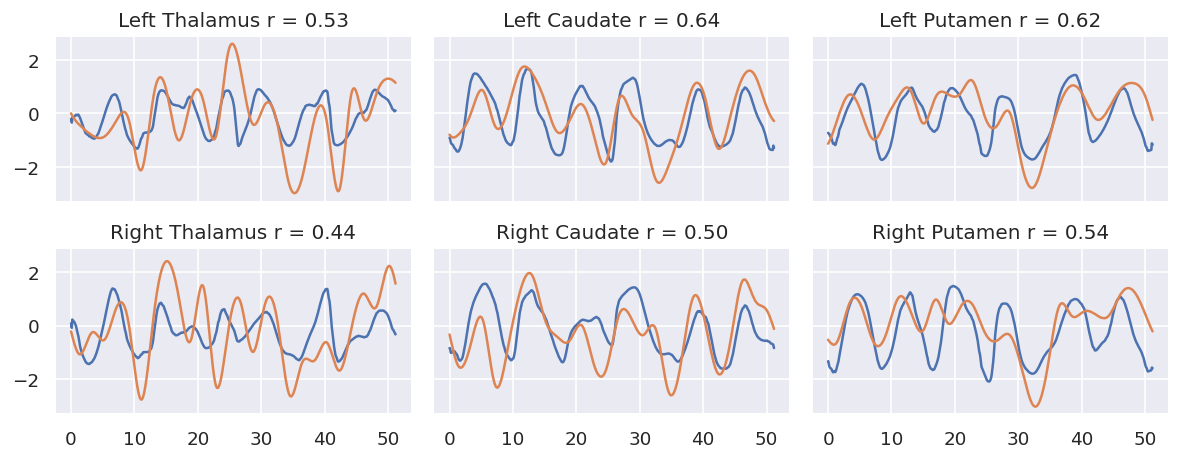

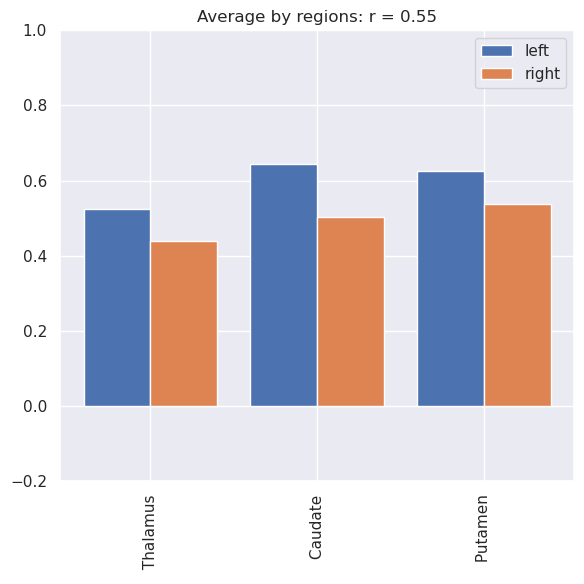

In [31]:
raw_test_data = test_dataset_prep
labels = labels_roi
inference_function = inference.model_inference_function
device = 'cuda'
to_many = True

fig, fig_bars, corrs = inference_function(model, raw_test_data, 
                                          labels=labels, 
                                          device=device, 
                                          to_many=to_many)

In [32]:
fig.savefig('../figures/ts_best_AE_0_54.pdf')
fig_bars.savefig('../figures/bars_best_AE_0_54.pdf') 

In [16]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad


ModuleNotFoundError: No module named 'pytorch_grad_cam'

In [34]:
raw_test_data[0].shape

(30, 16, 5500)

In [433]:
def simple(*kwargs):
    
    return a

In [436]:
simple(**dict(a=2, b=5))

TypeError: simple() got an unexpected keyword argument 'a'

In [371]:
x, y = raw_test_data
model = model.to(device)
model.eval()
bound = x.shape[-1]//1024 * 1024

X_test = x[..., :bound]
y_test = y[..., :bound]

y_batch = torch.from_numpy(y_test).float().to(device)
y_batch = torch.unsqueeze(y_batch, 0)

x_batch = torch.from_numpy(X_test).float().to(device)
x_batch = torch.unsqueeze(x_batch, 0)


y_hat = model(x_batch)[0]
y_hats = y_hat.to('cpu').detach().numpy()

In [372]:
# from pytorch_grad_cam import GradCAM

# class fMRITarget:
#     def __init__(self, region, y_true):
#         self.region = region
        
#         y_true = torch.from_numpy(y_true).float().to(device)
#         self.y_true = y_true
#     def __call__(self, model_output):
#         error = model_output - self.y_true 
#         return -error[self.region].sum()


# model.to(device)


# target_layers = [model.spatial_reduce.conv1d]
# targets = [fMRITarget(0, y_test)]
# with GradCAM(model=model,
#              target_layers=target_layers,
#              use_cuda=torch.cuda.is_available()) as cam:
#     grayscale_cam = cam(input_tensor=x_batch,
#                         targets=targets)
#     # cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# # Image.fromarray(cam_image)

In [373]:
class fmriWrapper(torch.nn.Module):
    def __init__(self, model, y_batch): 
        super(fmriWrapper, self).__init__()
        self.model = model
        self.y_batch = y_batch
        
    def forward(self, x):
        return -(self.model(x) - self.y_batch)**2
        # return self.model(x)

In [374]:
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients, GuidedBackprop, Saliency
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

The common idea is to compute the gradient of the network’s prediction with respect to the input, holding the weights fixed. This determines which input elements (e.g., which pixels in case of an input image) need to be changed the least to affect the prediction the most. The sole difference between the three approaches is how they backpropagate through the linear rectifier [(the ReLU)]. Only [Simonyan et. al’s “Gradients” approach] actually computes the gradient; the others modify the backpropagation step to do something slightly different. As we will see, this makes a crucial difference for the saliency maps!

In [375]:
x_batch = torch.tensor(x_batch, requires_grad=True)


/tmp/ipykernel_3202/402948971.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch = torch.tensor(x_batch, requires_grad=True)


roi 0


/tmp/ipykernel_3202/59133328.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


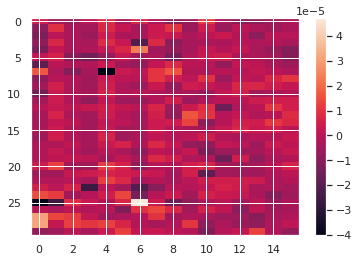

roi 1


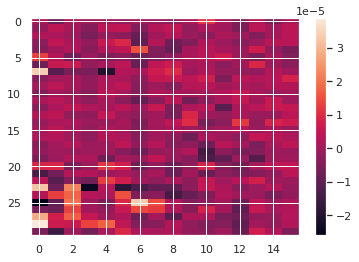

roi 2


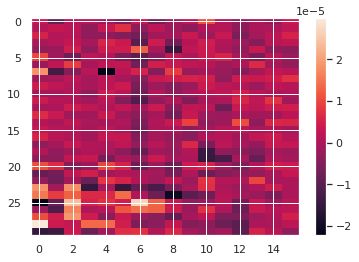

roi 3


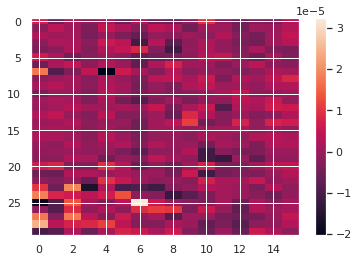

roi 4


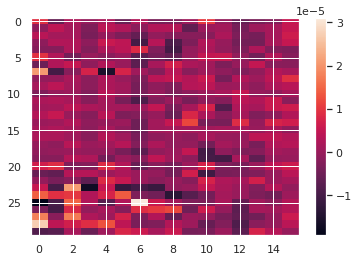

roi 5


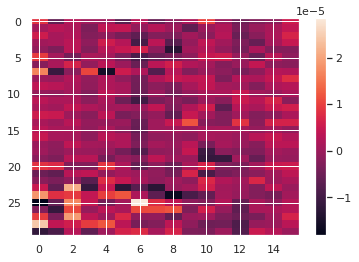

In [376]:
model_roi = fmriWrapper(model, y_batch)


# gbp = GuidedBackprop(model)
# ig = IntegratedGradients(model)
gradient = Saliency(model)

# ig = IntegratedGradients(net)

nt = NoiseTunnel(ig)


x_batch.requires_grad = True
x_batch = x_batch[..., :5000]
# input = torch.randn(2, 3, 32, 32, requires_grad=True)
# Computes Guided Backprop attribution scores for class 3.

attribution_freqs = []
matrixes = []
for roi in range(6):
    print('roi', roi)
    for i in range(0, 5000, 100):
        # baseline = torch.zeros_like(x_batch)+ torch.min(x_batch)
        attribution = gradient.attribute(x_batch, target=(roi, i), abs =False)
        # attribution = nt.attribute(x_batch, nt_type='smoothgrad',
                           # nt_samples=3, target=(roi, i))
        
        # attribution = torch.clip(attribution, 0, attribution.max())
        # attribution = torch.clip(attribution, attribution.min(), 0)
        
        # attribution = (attribution * x_batch).detach().numpy()  
        attribution = attribution.detach().numpy()
        
        
        attribution_freq = np.mean(attribution[0], -1)
        attribution_freqs.append(attribution_freq)
        # plt.imshow(attribution_freqs, aspect = 'auto')
        # plt.show()
        # plt.plot(np.mean(attribution_freqs, 0))
        # plt.show()

    matrix = np.mean(np.array(attribution_freqs), 0)
    matrixes.append(matrix)
    # matrix
    plt.imshow(matrix, aspect = 'auto')
    plt.colorbar()
    plt.show()

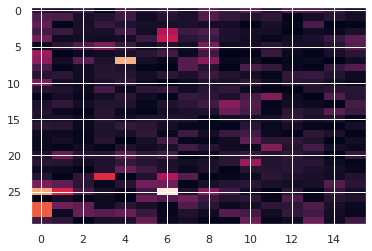

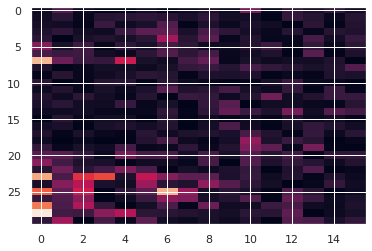

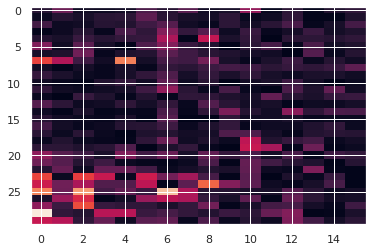

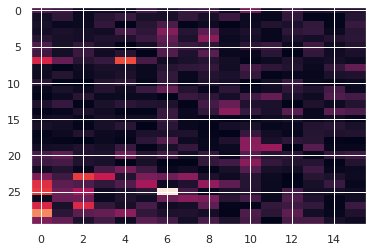

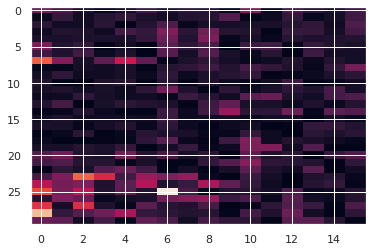

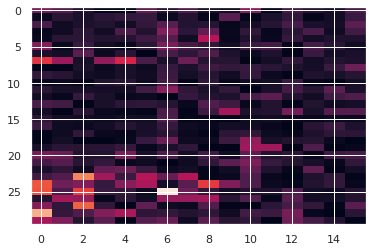

In [377]:
for i in range(6):
    plt.imshow(np.abs(matrixes[i]), aspect = 'auto')
    plt.show()

In [329]:
# matrixes_pos = matrixes.copy()

In [330]:
# matrixes_neg = matrixes.copy()

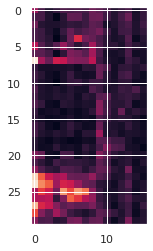

In [337]:
plt.imshow(np.abs(matrixes_pos[2]))

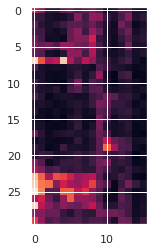

In [336]:
plt.imshow(np.abs(matrixes_neg[2]))

In [223]:
average = np.mean(np.array(matrixes), axis = 0)

In [230]:
diff = np.abs(np.array(matrixes)-  average)

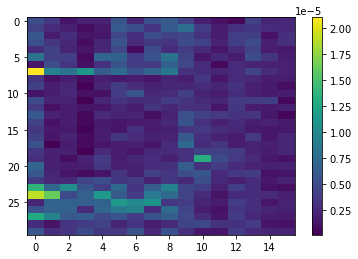

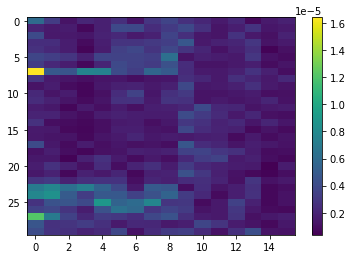

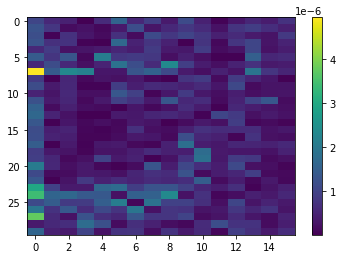

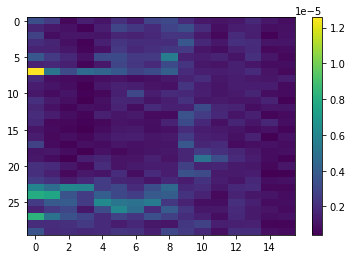

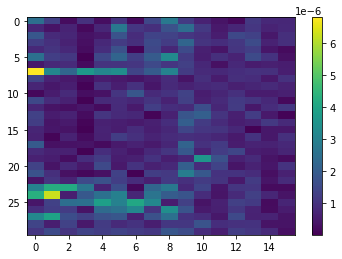

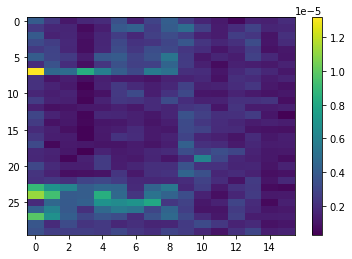

In [232]:
# matrixes.append(matrix)
# matrix
for i in range(6):
    plt.imshow(diff[i], aspect = 'auto') 
              # vmin = -17, vmax = -11)
    plt.colorbar()
    plt.show()

In [41]:
for i, freq in enumerate(config['freqs']):
    print(i, freq)

0 2.0
1 2.594201317699543
2 3.3649402383770237
3 4.364666200188945
4 5.66141140392441
5 7.343420462049961
6 9.525155519535902
7 12.355085500036555
8 16.025789542242673
9 20.78706217383076
10 26.96291204122704
11 34.97361097318403
12 45.36429383567262
13 58.84205542250558
14 76.32406885660676
15 99.0


In [391]:
top = np.mean(np.array(matrixes), 0)

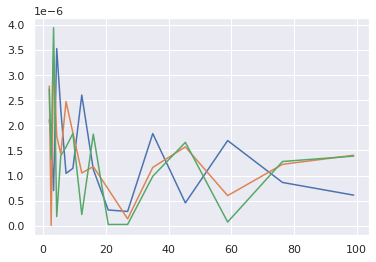

In [416]:
plt.plot(config['freqs'], np.abs(np.mean(matrixes[0], 0)))
plt.plot(config['freqs'], np.abs(np.mean(matrixes[1], 0)))
plt.plot(config['freqs'], np.abs(np.mean(matrixes[2], 0)))
# plt.plot(config['freqs'], np.abs(np.mean(matrixes[1], 0)))

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


(<matplotlib.image.AxesImage at 0x7f95321229a0>,
 <matplotlib.contour.QuadContourSet at 0x7f9532165a90>)

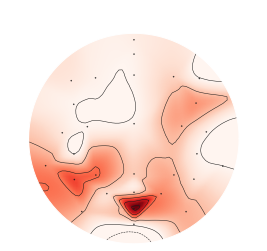

In [398]:
mne.viz.plot_topomap(np.mean(top, -1)**2, pos = info, show=False)

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packa

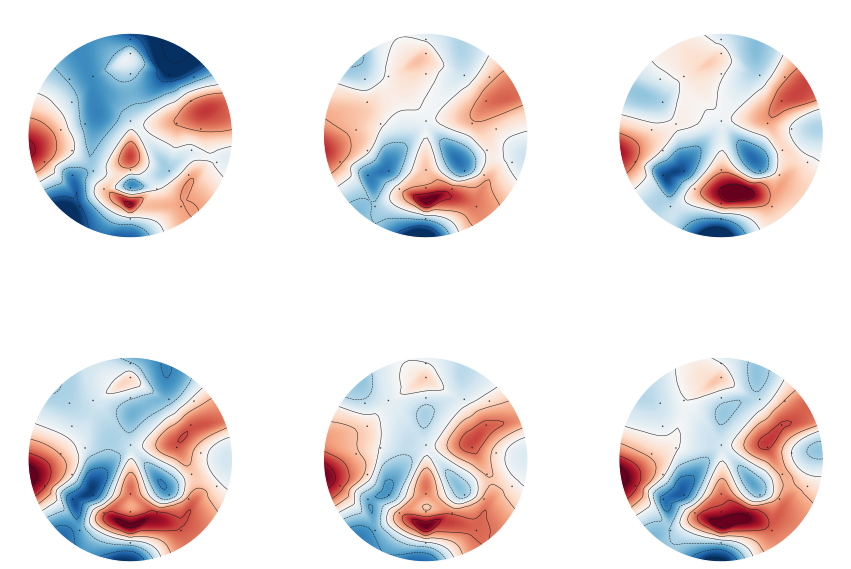

In [420]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
for i in range(3):
    mne.viz.plot_topomap(np.mean(matrixes[i], -1), pos = info, show=False, axes = ax[0, i])
    # plt.show()
for i in range(3):
    mne.viz.plot_topomap(np.mean(matrixes[i+3], -1), pos = info, show=False, axes = ax[1, i])
    # plt.show()

In [421]:
fig.savefig('../figures/topomaps.pdf')

In [240]:
labels

['Left Thalamus',
 'Left Caudate',
 'Left Putamen',
 'Right Thalamus',
 'Right Caudate',
 'Right Putamen']

In [241]:
freqs

NameError: name 'freqs' is not defined

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packa

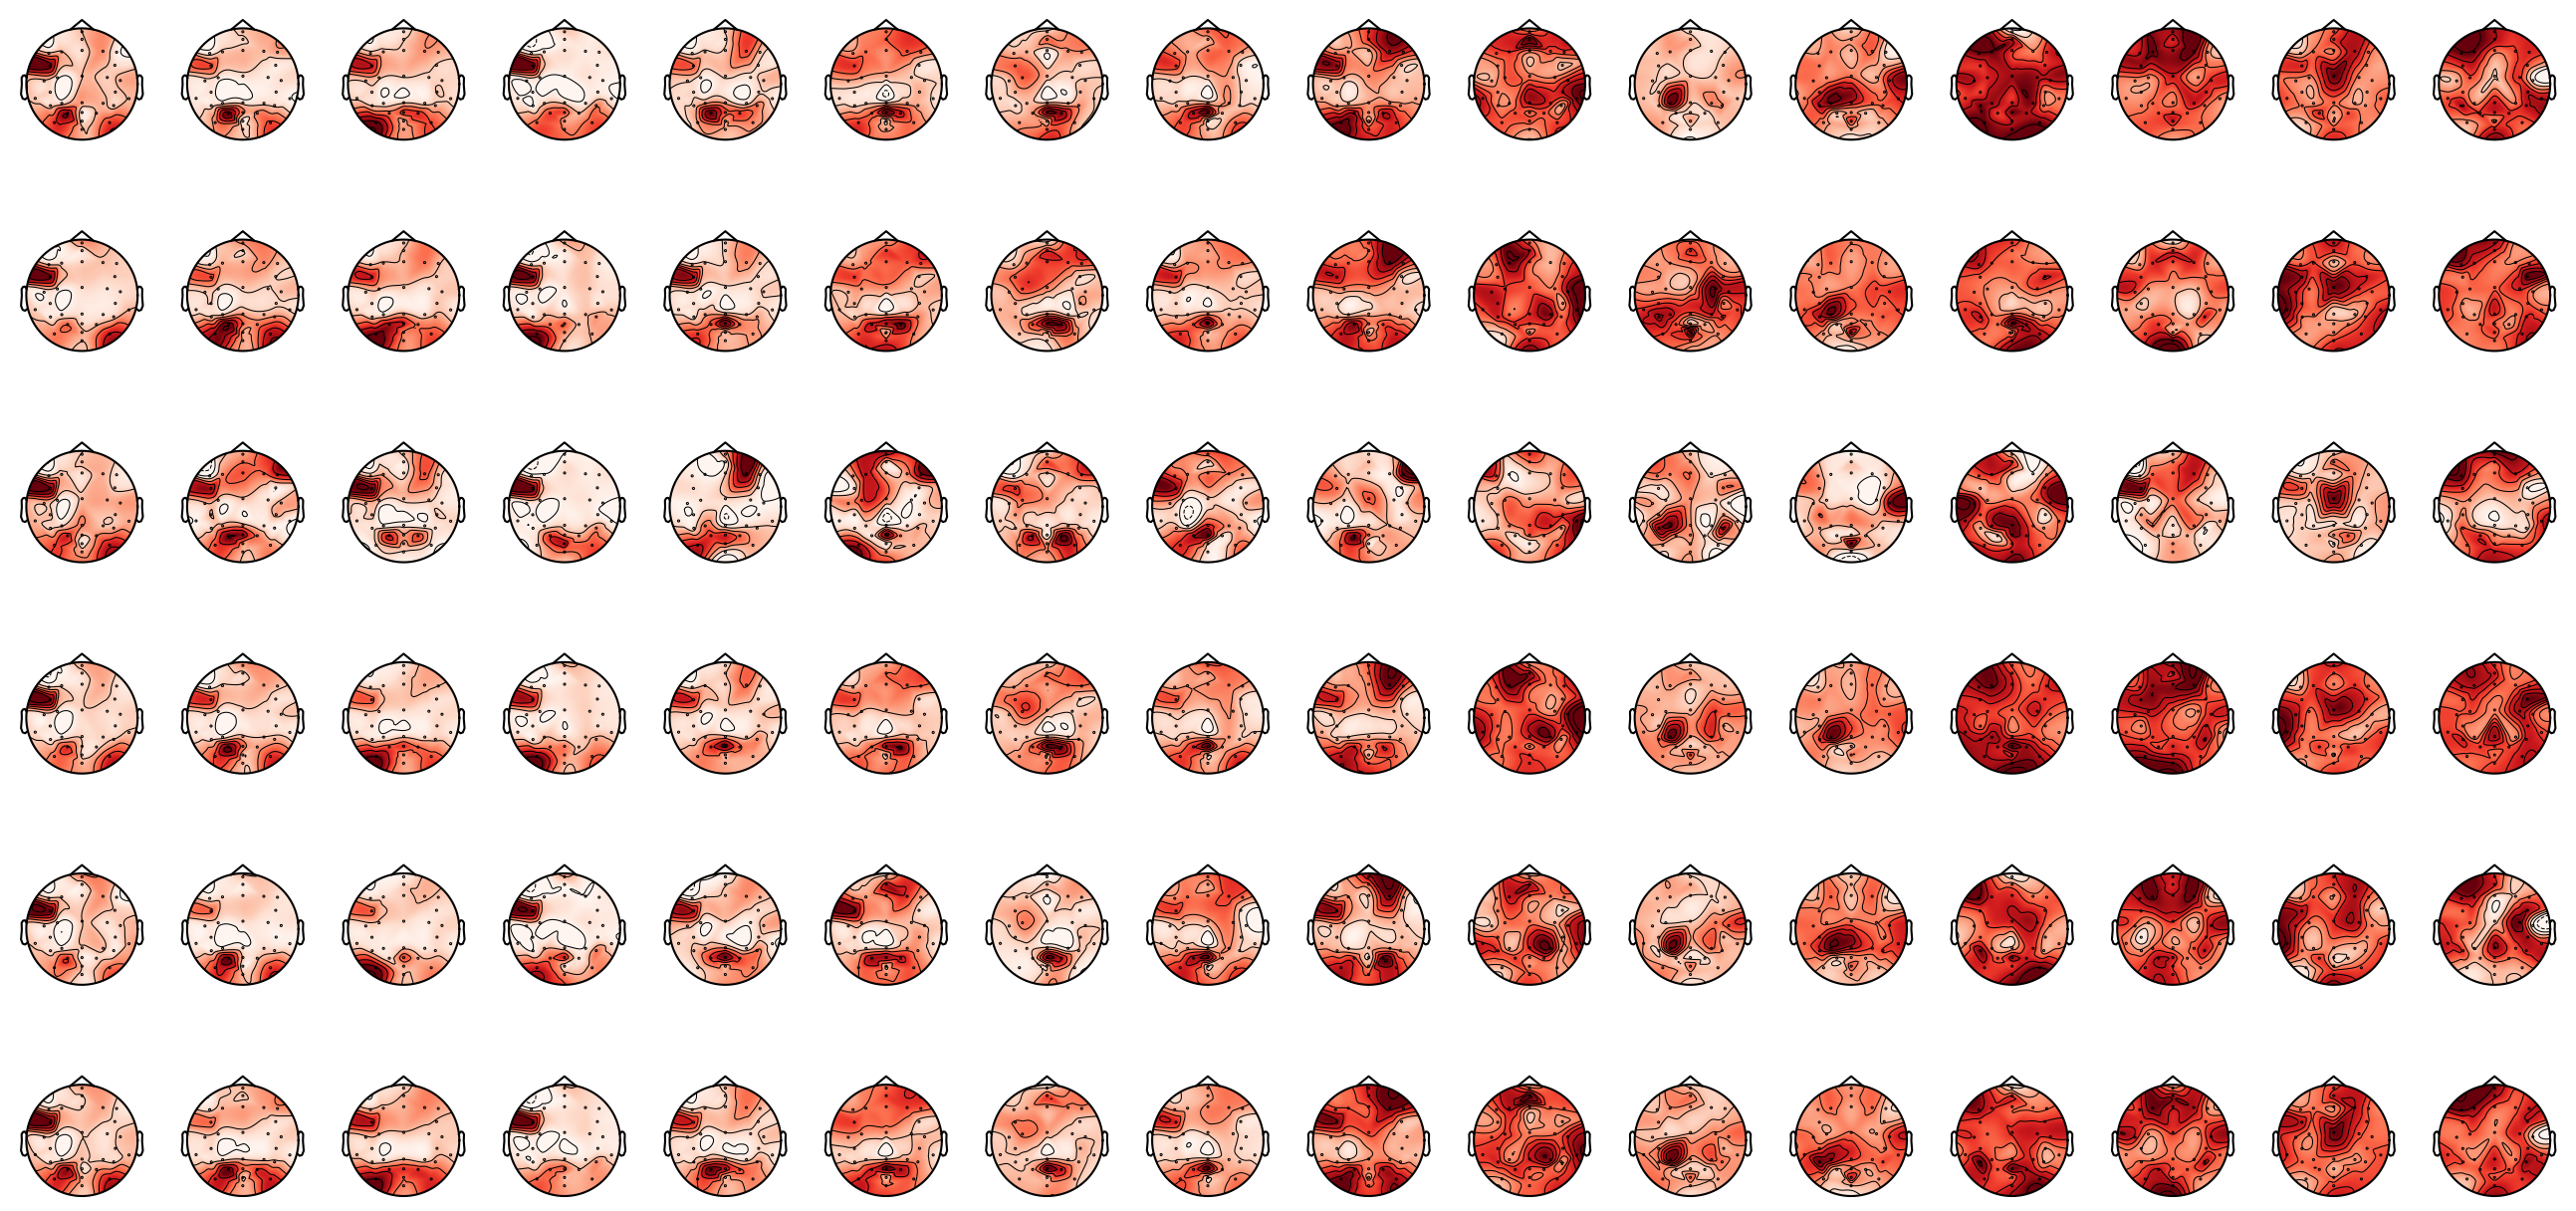

In [247]:
fig, axes = plt.subplots(6, 16, figsize = (22, 10), dpi = 150)
i = 0
# axis = ax.flat
for roi in range(6):
    for freq in range(16):
        data = diff[roi][:, freq]
        ax = axes[roi,freq]
        # ax.set_title(f"Roi {roi}, Band {config['freqs'][freq]} Hz")
        mne.viz.plot_topomap(data, pos = info, axes=ax, show=False)
        # ax.flat[i].plot(np.ones(5))
        i  = i +  1 
# plt.show()

In [248]:
fig.savefig('topomaps.png')

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


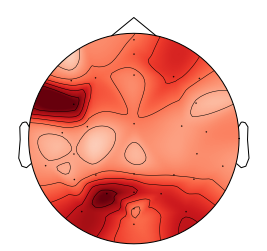

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


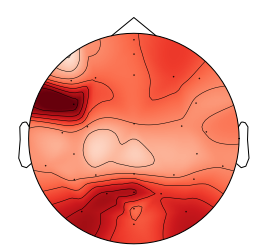

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


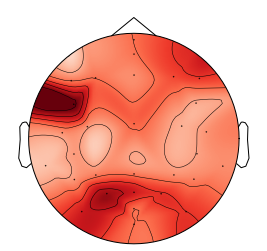

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


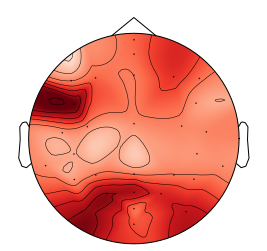

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


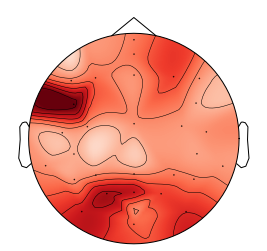

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


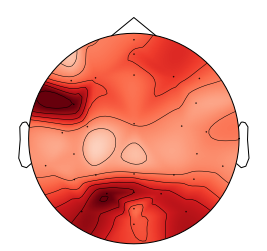

In [185]:
for roi in range(6):
    # plt.plot(np.mean(matrixes[roi], 0))
    # plt.plot(np.mean(np.abs(matrixes[roi] - average), 1))
    mne.viz.plot_topomap(np.mean(np.abs(matrixes[roi] - average), 1), pos = info)
    plt.show()
# plt.plot(matrixes[1][0])

In [ ]:
attribution.numpy()

In [ ]:
print(attribution.shape)
# attribution = np.abs((attribution * x_batch).detach().numpy())
attribution_reshape = attribution[0].reshape(16*30, -1)

attribution_freqs = np.mean(attribution[0], -1)

In [ ]:
attribution_freqs.shape
plt.imshow(attribution_freqs, aspect = 'auto')


In [ ]:
plt.plot(attribution[0][0].**0.5, aspect = 'auto')


In [ ]:
plt.figure(figsize = (15, 7))
plt.imshow(attribution_reshape**0.5, aspect = 'auto')
plt.colorbar()

In [ ]:
plt.plot(np.mean(attribution_reshape**0.5, 0))


In [ ]:
plt.imshow(attribution[0, :, :, 0])

In [ ]:
X_test = x_batch
baseline = y_batch

# ig = IntegratedGradients(model)
# ig_nt = NoiseTunnel(ig)
# dl = DeepLift(model)
gs = GradientShap(model_roi)
fa = FeatureAblation(model_roi)

# ig_attr_test = ig.attribute(X_test, n_steps=50, target = 0)
# ig_nt_attr_test = ig_nt.attribute(X_test)
# dl_attr_test = dl.attribute(X_test)
# gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

In [ ]:
weight = model.spatial_reduce.conv1d.weight
weight = weight.detach().numpy()

In [ ]:
weight_sum = np.mean(weight, -1)

In [ ]:
plt.imshow(np.abs(weight_sum[:, :]), aspect = 'auto')

In [ ]:
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(input, baseline, target=0, return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)